Training fundamentals
Here, a pytorch model is trained on a straight line dataset

5 Steps
1. Getting data
2. Model Build
3. Fitting (Model Training)
4. Val+Test
5. Save and load

In [1]:
#importing
import torch
from torch import nn #for neural net building
import matplotlib.pyplot as plt

c:\Users\Mallinathan G\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Mallinathan G\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\Mallinathan G\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\Mallinathan G\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Data preps and loading
#Generating data of X and Y of a straight line
w = 0.7
bias = 0.3
#Formulation
x = torch.arange(0, 1, 0.02).unsqueeze(dim=1)
y  = w*x + bias
print(x[:10], y[:10])

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]]) tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])


Train Test Split
Train -> Training; Test -> Testing; Validation -> optimising model (optional)

In [3]:
#Creating Test Train Split
train_split = int(.8*len(x)) #80:20 Split
x_train, y_train = x[:train_split], y[:train_split]
x_test, y_test = x[train_split:], y[train_split:]

print(len(x_train), len(x_test), len(y_train), len(y_test))

40 10 40 10


Data Visualisation

In [4]:
def plot_predictions(train_data = x_train, train_labels = y_train, test_data = x_test, test_labels = y_test, predictions = None):
    plt.figure(figsize=(10, 10))
    #train plot
    plt.scatter(train_data, train_labels, c = "black", s=4, label = "Training")
    #test plot
    plt.scatter(test_data, test_labels, c = "b", s=4, label = "Test")
    if predictions is not None:
        #predictio  plot
        plt.scatter(test_data, predictions, c = "g", s=4, label = "Predictions")
    plt.legend(prop= {"size": 14})    

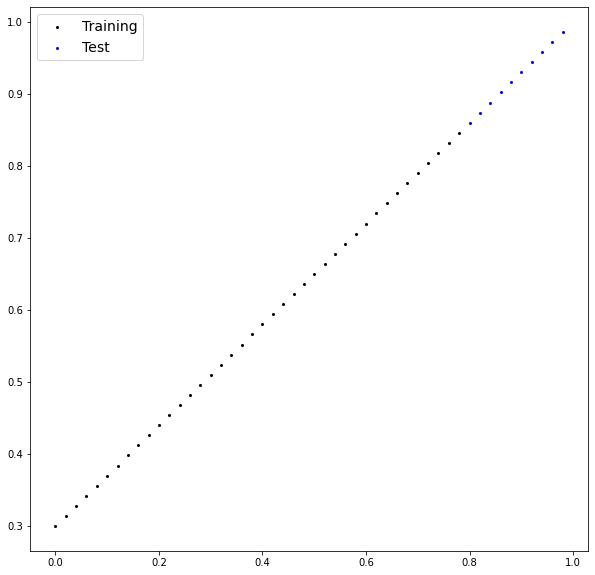

In [5]:
plot_predictions()

Implimenting a simple linear regression model using class (Basic Implimentation)
1. torch.nn -> parent library (class) of all definitions contains all building blocks (layers)
2. torch.nn.parameter -> contains params like weights and biases
3. nn.Module ->direct parent of defined class (LinearRegressionModel)
4. def forward(): -> must have function defining the computation logics of the defined module
5. torch.optim -> contains hyperparms like optimizers

In [6]:
#Defining a child class of nn module class
class LinearRegressionModel(nn.Module):
    def __init__(self): #Constructor for the child class
        super().__init__() #Force call of the constructor of its parent class
        self.weights = nn.Parameter(torch.randn(1,          #1 dim unit random tensor
                                    dtype=torch.float),    #of float type
                                    requires_grad=True)   #to enable track operations in forward pass to compute gradients automatically during back prop
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float),requires_grad=True)
    #defining a forward pass function (logistic regression)
    #Taking self and x as the input (x being tensor)
    #-> torch.Tensor represents the return value
    def forward(self, x : torch.Tensor) -> torch.Tensor: 
        return self.weights * x + self.bias #Logistic regression formula    

Checking the contents of the defined model using .parameters() function

In [7]:
#set random seed
torch.manual_seed(42)
#creating an object
model_0 = LinearRegressionModel()
#Listing the parameters
print(list(model_0.parameters()))
#gettting state in a dict format
print(model_0.state_dict())

[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]
OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])


Initial predictions using x_test and torch.inference_mode()
1. This function will automatically call the defined forward function
2. This function switches off a few things like gradient tracking (as it is a predicting function and requires no backprop) making faster inferences
3. Since the data is not trained, the prediction is a line based on the randomly generated values

Error:  tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])


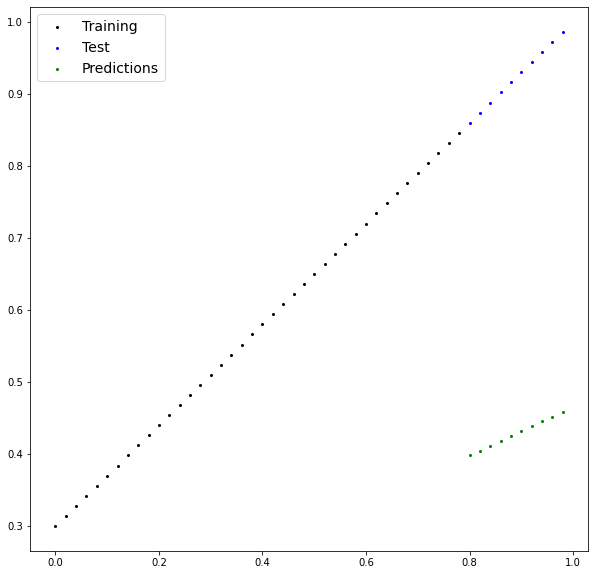

In [8]:
with torch.inference_mode():
    y_pred = model_0(x_test)
plot_predictions(predictions=y_pred)
print("Error: ", (y_test - y_pred))

Training

Deep learning notes covers it in detail
1. Training mainly requires 2 things: loss function and optimizer
2. Mean Absolute error (torch.nn.L1Loss()) for regression and Binary cross entropy for classification (tirch.nn.BCELoss()) are popular loss functions
3. Adam or SGD (in one note) are popular optimizers.
The following code illustrates the setup

In [9]:
#Loss function
loss_func = nn.L1Loss()
#Optimiser
optimiser = torch.optim.SGD(params=model_0.parameters(), lr = 0.01) #setting learning rate as 0.01 for model_0 params

The training and testing phase can be detailed as follows

Training
1. Set to train mode using model.train() (this in default)
2. Forward pass using model(x_train)
3. calculate the loss between predicted value and true label value using loss_func()
4. do optimiser.zero_grad() to avoid gradient accumulation over epochs 
5. perform back prop on the obtained loss function
6. Do optimiser.step() to update the models params based on calculated values from backprop

Testing
1. set to model.eval() mode to disable some training functionality
2. with indference_mode() do prediction usin model(x_test) inference mode makes gaining inferece faster
3. compute loss value using loss function
4. Display all the values

In [10]:
torch.manual_seed(42)

epochs = 100

#creating lists to display the loss and epoch values

train_loss_values = [] #Holds just loss values (mean of all losses here)
test_loss_values = []
epoch_count = []

for epoch in range(epochs):

    #Training mode
    model_0.train()

    #Forward Pass
    y_pred = model_0(x_train) 

    #compute train loss
    train_loss = loss_func(y_pred, y_train)  #holds grad function and train loss value for backprop

    #optimiser zero 
    optimiser.zero_grad()

    #backprop
    train_loss.backward()

    #progress optimiser
    optimiser.step()

    ##Testing: eval mode
    model_0.eval()

    with torch.inference_mode():
        test_pred = model_0(x_test)

        test_loss = loss_func(test_pred, y_test)

    #printing every 10 epochs
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        train_loss_values.append(train_loss.detach().numpy())
        test_loss_values.append(test_loss.detach().numpy())
        print(f"epoch: {epoch} || Train Loss: {train_loss} || Test Loss: {test_loss}")

epoch: 0 || Train Loss: 0.31288138031959534 || Test Loss: 0.48106518387794495
epoch: 10 || Train Loss: 0.1976713240146637 || Test Loss: 0.3463551998138428
epoch: 20 || Train Loss: 0.08908725529909134 || Test Loss: 0.21729660034179688
epoch: 30 || Train Loss: 0.053148526698350906 || Test Loss: 0.14464017748832703
epoch: 40 || Train Loss: 0.04543796554207802 || Test Loss: 0.11360953003168106
epoch: 50 || Train Loss: 0.04167863354086876 || Test Loss: 0.09919948130846024
epoch: 60 || Train Loss: 0.03818932920694351 || Test Loss: 0.08886633068323135
epoch: 70 || Train Loss: 0.03476089984178543 || Test Loss: 0.0805937647819519
epoch: 80 || Train Loss: 0.03132382780313492 || Test Loss: 0.07232122868299484
epoch: 90 || Train Loss: 0.02788739837706089 || Test Loss: 0.06473556160926819


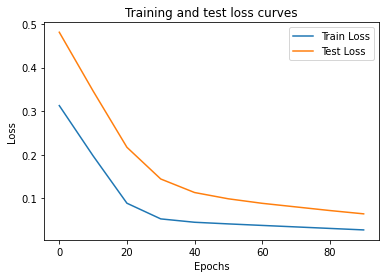

In [11]:
#plotting the values
plt.plot(epoch_count, train_loss_values, label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [12]:
#comparing the predicted weights with the actual weights w=0.7 and b - 0.3
print(model_0.state_dict())

OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])


Plotting the predictions

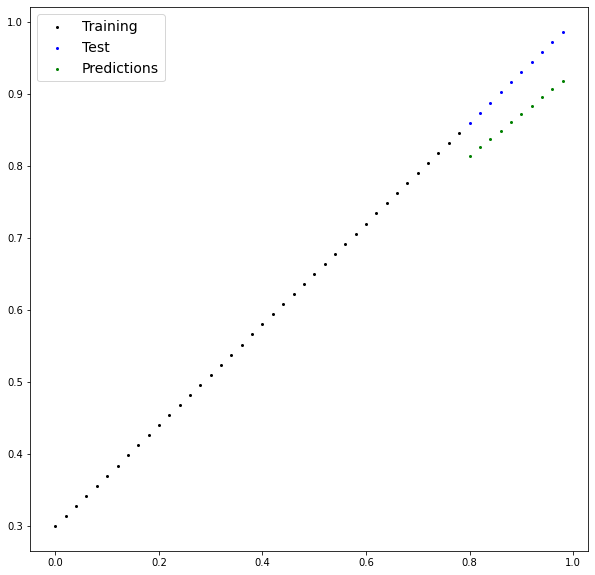

In [13]:
plot_predictions(predictions=test_pred)

Saving and loading the model

torch.save saves the model using python's pickle utility

torch.load loads the model from the same utility

torch.nn.load_state_dict loads model's learned params stored as a state_dict

In [37]:
#saving the model
from pathlib import Path
#creating a directory
path = "models"
model_name = "Pytorch_workflow_fundamentals.pth"
model_save_path = f"{path}\{model_name}"

#saving the model

print(f"Saving model to {model_save_path}")
torch.save(obj=model_0.state_dict(), f=model_save_path)

Saving model to models\Pytorch_workflow_fundamentals.pth


In [38]:
#loading the model
#since only the state_dict is saved, the a new model instance needs to be created and put these learned params into it. This practise is carried out so as 
#to maintain uniformaity across the community

loaded_model = LinearRegressionModel() #new object

loaded_model.load_state_dict(torch.load(f=model_save_path))


<All keys matched successfully>